In [1]:
import cgc
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from cgc.coclustering import Coclustering

from dask_yarn import YarnCluster
from dask.distributed import Client

# Co-clustering with CGC and Dask YARN cluster

## Setup Dask cluster

In [2]:
# Create a cluster
cluster = YarnCluster(environment="environment-cgc.tar.gz")

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.34.143:40935
distributed.scheduler - INFO -   dashboard at:                    :44595


In [3]:
# Scale to 2 workers
cluster.scale(2)
cluster

distributed.scheduler - INFO - Register worker <Worker 'tcp://172.31.40.228:33225', name: dask.worker_0, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.40.228:33225
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://172.31.44.171:33681', name: dask.worker_1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.44.171:33681
distributed.core - INFO - Starting established connection


In [4]:
# connect client
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-77789607-98aa-11eb-a883-0696c738b548
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://172.31.34.143:40935 Dashboard: /proxy/44595/status,Cluster Workers: 2 Cores: 2 Memory: 4.00 GiB


## Co-clustering: Test case

In [5]:
from sklearn.datasets import make_checkerboard

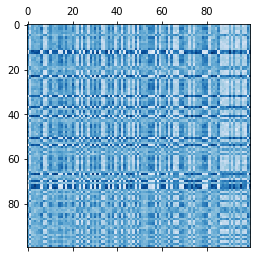

In [6]:
# generate matrix with checker-board pattern, shuffled
nclusters_row, nclusters_col = (4, 3)
data, rows, columns = make_checkerboard(
    shape=(100, 100), 
    n_clusters=(nclusters_row, nclusters_col), 
    noise=5,
    shuffle=True, 
    random_state=1
)

plt.matshow(data, cmap=plt.cm.Blues)
plt.show()

In [7]:
# setup co-clustering analysis
cc = Coclustering(
    data, 
    nclusters_row=nclusters_row, 
    nclusters_col=nclusters_col,
    max_iterations=10,
    nruns=100,
)

# run! 
res = cc.run_with_dask(client=client)

distributed.scheduler - INFO - Receive client connection: Client-worker-7f2bc64a-98aa-11eb-b1dd-06ab20b233b0
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Receive client connection: Client-worker-7f42d005-98aa-11eb-9e79-0611156b2f6e
distributed.core - INFO - Starting established connection


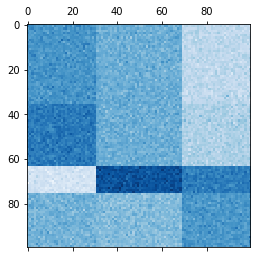

In [8]:
# rearrange the matrix using co-clusters
data_clustered = data[np.argsort(res.row_clusters)]
data_clustered = data_clustered[:, np.argsort(res.col_clusters)]

plt.matshow(data_clustered, cmap=plt.cm.Blues)
plt.show()

## Co-clustering: Real data

In [28]:
# read USA mask
mask = xr.open_rasterio('s3://twente-spark-emr-hello-world/test-data/usa_mask.tif')
mask = ~mask.isnull()

In [29]:
# read subset of first-leaf spring-index dataset
years = range(1990, 2000)
spring_index = [
    xr.open_rasterio(f's3://twente-spark-emr-hello-world/test-data/'
                     f'spring-index/LeafFinal_one_band/{year}.tif') 
    for year in years
]
spring_index = [da.where(mask) for da in spring_index]
spring_index = xr.concat(spring_index, dim='time')
spring_index = spring_index.squeeze('band', drop=True)  # drop band dimension

# set year as time coordinate
spring_index = spring_index.assign_coords(year=('time', years))

In [30]:
# make data coarser for test purposes
coars = spring_index.coarsen({'x': 10, 'y': 10}, boundary="trim")
spring_index = coars.mean()

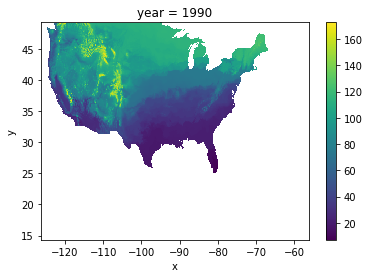

In [31]:
# show example
spring_index.isel(time=0).plot.imshow()

In [32]:
spring_index = spring_index.stack(space=['x', 'y'])
location = np.arange(spring_index.space.size) # create a combined (x,y) index
spring_index = spring_index.assign_coords(location=('space', location))

# drop pixels that are null-valued for any of the time indices
spring_index_finite = spring_index.dropna('space', how='any')  

In [34]:
# size of the matrix
spring_index_finite.shape, spring_index_finite.nbytes / 2**20,  "MB"

((10, 102975), 7.8563690185546875, 'MB')

In [35]:
# setup co-clustering analysis
nclusters_row = 3  # time
nclusters_col = 20 # space

cc = Coclustering(
    spring_index_finite.data, 
    nclusters_row=nclusters_row, 
    nclusters_col=nclusters_col,
    max_iterations=100,
    nruns=20,
)

# run! 
res = cc.run_with_dask(client=client, low_memory=True)

In [36]:
# create data arrays from row/col clusters
time_clusters = xr.DataArray(res.row_clusters, dims='time', 
                             coords=spring_index.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(res.col_clusters, dims='space', 
                              coords=spring_index.space.coords, 
                              name='space cluster')

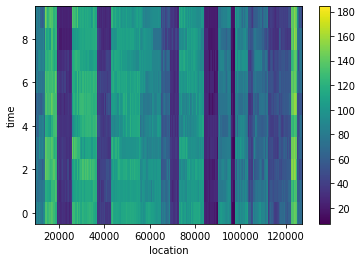

In [48]:
# sort dataset 
spring_index = spring_index.assign_coords(time_clusters=time_clusters, 
                                          space_clusters=space_clusters)
spring_index_sorted = spring_index.sortby(['time_clusters', 
                                           'space_clusters'])

ax = spring_index_sorted.plot.imshow(x='location', y='time')

## Shutdown Dask cluster

In [49]:
client.close()
cluster.shutdown()

distributed.scheduler - INFO - Remove client Client-77789607-98aa-11eb-a883-0696c738b548
distributed.scheduler - INFO - Remove client Client-77789607-98aa-11eb-a883-0696c738b548
distributed.scheduler - INFO - Close client connection: Client-77789607-98aa-11eb-a883-0696c738b548
distributed.scheduler - INFO - Scheduler closing...
distributed.scheduler - INFO - Scheduler closing all comms
distributed.scheduler - INFO - Remove worker <Worker 'tcp://172.31.40.228:33225', name: dask.worker_0, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://172.31.40.228:33225
distributed.scheduler - INFO - Remove worker <Worker 'tcp://172.31.44.171:33681', name: dask.worker_1, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://172.31.44.171:33681
distributed.scheduler - INFO - Lost all workers
tornado.application - ERROR - Exception in callback functools.partial(<function TCPServer._handle_connection.<locals>.<lambda> at 0x7f8c76f8f310>, <Task finished nam